In [1]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
# Set engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Reflect database
Base = automap_base()
# Reflect tables
Base.prepare(engine, reflect=True)

In [4]:
# View reflected table names
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create session 
session = Session(engine)

In [7]:
# Find latest date
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

# Extract date from search
latestDate = list(np.ravel(latestDate))[0]

# Convert the date
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

# Pull year, month, and date 
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

# Calculate one year prior
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

# Sort the dataframe by date
rainTable = rainTable.sort_index(ascending=True)

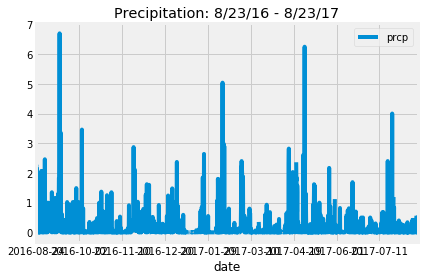

In [8]:
# Create Precipitation Table
rainTable.plot(title="Precipitation: 8/23/16 - 8/23/17")
plt.tight_layout()

In [10]:
# Summarize the data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Set the most active station
stationID = stationCounts[0][0]

#Query for station name
stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#Query for highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")

#Query for lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")

#Query for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


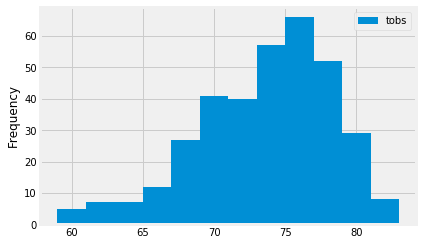

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query for the last year of temperature data
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

# Convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

# Sort by date
tempTable = tempTable.sort_index(ascending=True)

# Histogram plot 
tempTable.plot(kind='hist', bins=12)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#set trip dates and previous dates
trip = '2020-07-26 to \n 2020-07-30'
tripStartDate = '2017-07-26'
tripEndDate = '2017-07-30'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_temps(tripStartDate, tripEndDate)

tripTemps

[(73.0, 79.21875, 84.0)]

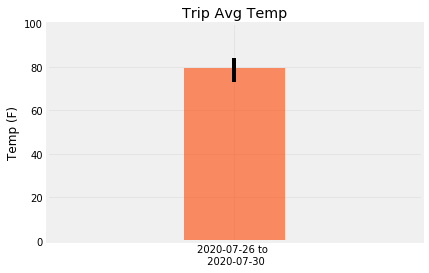

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query for precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

# Convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))

# Rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.3,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.45,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.25,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.18,21.5213,-157.8374,7.0
4,USC00517948,"PEARL CITY, HI US",0.01,21.3934,-157.9751,11.9
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0,21.33556,-157.71139,19.5
6,USC00519397,"WAIKIKI 717.2, HI US",0.0,21.2716,-157.8168,3.0
